```
@beelzebruno
2022
```

<hr />

# Save te princess

This is an ludic abstraction to a graph extraction from a given matrix.
Sometimes we got problems that implies the use os search algorithms to find a
solution to a problem, and this problem comes presented in the shape of a matrix.

Suppose we have a scenary where theres a lost princess somewhere in a region
mapped in a (x, y) coordinates chart, as well we have a hero in the mission of
find and rescue the lost princess:

![lost princess map](https://github.com/brunolcarli/GooGraph/blob/master/static/img/hero_princess_map.png?raw=true)

The red **X** marks are places the hero cannot pass or access.

**Find solutions to help our hero search the best path to the lost princess**

In [70]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

plt.style.use('seaborn')

In [2]:

numbers = list(range(70))
matrix = [
    numbers[:10],
    numbers[10:20],
    numbers[20:30],
    numbers[30:40],
    numbers[40:50],
    numbers[50:60],
    numbers[60:70]
]
walls = [
    (3, 0), (1, 1), (2, 3), (3, 3), (4, 3),
    (4, 4), (6, 4), (1, 5), (4, 5), (1, 7),
    (5, 7), (3, 8), (6, 8), (2, 9)
]
for wall in walls:
    x, y = wall
    matrix[x][y] = None

matrix_df = pd.DataFrame(matrix)
matrix_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,2,3.0,4.0,5.0,6,7.0,8.0,9.0
1,10.0,NaN,12,13.0,14.0,NaN,16,NaN,18.0,19.0
2,20.0,21.0,22,NaN,24.0,25.0,26,27.0,28.0,NaN
3,NaN,31.0,32,NaN,34.0,35.0,36,37.0,NaN,39.0
4,40.0,41.0,42,NaN,NaN,NaN,46,47.0,48.0,49.0
5,50.0,51.0,52,53.0,54.0,55.0,56,NaN,58.0,59.0
6,60.0,61.0,62,63.0,NaN,65.0,66,67.0,NaN,69.0


In [123]:
class Node:
    def __init__(self, value, coord):
        self.value = value
        self.coord = coord
        self.connections = []

    def __repr__(self):
        return str(self.value)


class Graph:
    def __init__(self, nodes=None):
        self.nodes = nodes or {}


class Agent:
    def __init__(self, world, start_position: tuple, target: tuple):
        self.effort = 0
        self.world = world
        self.current_position = start_position
        self.previous_position = None
        self.movements = 0
        self.target = target
        self.graph = Graph()
        self.buffer = [self.current_position]
        self.location_visit_count = self.update_visits()
        self.history_transition = []
        

    def update_visits(self):
        self.location_visit_count = Counter(self.buffer)
        self.effort += 1
        return self.location_visit_count

    def possible_moves(self, reference):
        x, y = reference
        options = (
            (x - 1, y),  # up
            (x + 1, y),  # down
            (x, y + 1),  # right
            (x, y - 1)  # left
        )
        self.effort += 1
        return [option for option in options if self.valid_movement(option)]

    @property
    def node(self):
        """ Return current position as Node object """
        x, y = self.current_position
        self.effort += 1
        return Node(self.world[x][y], self.current_position)

    def to_node(self, position):
        """ Return a position as Node object """
        x, y = position
        self.effort += 1
        return Node(self.world[x][y], position)

    def valid_movement(self, position: tuple):
        """ Check if position to move is a valid position """
        self.effort += 1
        new_x, new_y = position

        invalid_x_range = new_x > len(self.world)-1 or new_x < 0
        invalid_y_range = new_y > len(self.world[0])-1 or new_y < 0
        if invalid_x_range or invalid_y_range:
            return False

        new_position = self.world[new_x][new_y]
        if new_position is None:
            # is a wall, cannot pass
            return False
        
        # check if movement reachable
        x, y = self.current_position
        if abs(new_x - x) > 1 or abs(new_y - y) > 1:
            # maxx step size is one
            return False

        # is valid to move
        return True

    def move(self, position: tuple):
        self.effort += 1
        if not self.valid_movement(position):
            raise Exception(f'Cannot move to the position {position}')

        self.graph.nodes[str(self.node)] = self.node
        self.previous_position = self.current_position
        self.current_position = position
        self.buffer.append(self.current_position)
        self.update_visits()
        self.movements += self.location_visit_count.get(position, 1)

        self.history_transition.append((
            f'Move from {self.previous_position} to {self.current_position}',
            self.effort
        ))

        return self

    def check_position(self):
        """
        Return True if princess is in the current position.
        """
        self.effort += 1
        return self.current_position == self.target

    def select_best_option(self, strategy='a_star'):
        strategies = {
            'a_star': self.a_star,
            'bfs': self.bfs
        }
        # valid options given the current position
        options = [move for move in self.possible_moves(self.current_position)]
        if not options:
            return

        possibilities = []
        for option in options:
            move = strategies[strategy](
                option,
                self.target
            )
            self.effort += 1
            possibilities.append(move)
        return sorted(possibilities, key=lambda x: x[1])[0][0] if possibilities else None

    def a_star(self, start, target):
        """ A* search """
        h = lambda x: self.to_node(x).value - self.to_node(target).value
        f = lambda x: abs(self.location_visit_count.get(x, 0) + h(x))
        explored = set()
        queue = [(start, f(start))]

        while queue:
            position, _ = queue.pop(0)

            if position == target:
                return start, f(start), position, f(position)

            explored.add(position)
            areas = [area for area in self.possible_moves(position)
                     if self.valid_movement(area)]
            for area in areas:
                if area not in explored:
                    queue.append((area, f(area)))
                self.effort += 1
        
            queue = sorted(queue, key=lambda k: k[1])
        return start, f(start), position, f(position)

    def bfs(self, start, target):
        queue = [start]
        count = 0
        explored = set()
        while queue:
            position = queue.pop(0)
            count += self.location_visit_count.get(position, 0)
            if position == target:
                return start, count
            explored.add(position)
            areas = [area for area in self.possible_moves(position) if self.valid_movement(area)]
            for area in areas:
                if area not in explored:
                    queue.append(area)
                self.effort += 1
        return start, count

    def run(self, strategy='a_star'):
        while not self.check_position():
            self.effort += 1
            next_move = self.select_best_option(strategy)
            if not next_move:
                break
            
            self.move(next_move)
        print('Done')

In [129]:
PRINCESS_POSITION = (1, 8)

hero = Agent(matrix, (5, 1), PRINCESS_POSITION)
hero.run()


Done


In [130]:
hero.movements

751

In [131]:
df = pd.DataFrame(hero.history_transition, columns=['History', 'Effort'])
df

,History,Effort
0,"Move from (5, 1) to (4, 1)",880
1,"Move from (4, 1) to (3, 1)",1492
2,"Move from (3, 1) to (2, 1)",1904
3,"Move from (2, 1) to (2, 0)",2195
4,"Move from (2, 0) to (2, 1)",2297
...,...,...
104,"Move from (0, 6) to (0, 7)",26669
105,"Move from (0, 7) to (0, 6)",26743
106,"Move from (0, 6) to (0, 7)",26890
107,"Move from (0, 7) to (0, 8)",26964


<AxesSubplot:>

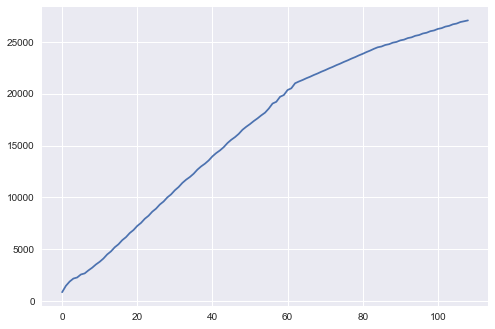

In [132]:
df.Effort.plot()

In [124]:
hero2 = Agent(matrix, (5, 1), PRINCESS_POSITION)
hero2.run('bfs')

KeyboardInterrupt: 

In [127]:
df2 = pd.DataFrame(hero2.history_transition, columns=['History', 'Effort'])
df2

,History,Effort
0,"Move from (5, 1) to (4, 1)",621
1,"Move from (4, 1) to (3, 1)",1109
2,"Move from (3, 1) to (2, 1)",1446
3,"Move from (2, 1) to (3, 1)",1686
4,"Move from (3, 1) to (2, 1)",2023
...,...,...
9177,"Move from (2, 1) to (3, 1)",2648385
9178,"Move from (3, 1) to (2, 1)",2648722
9179,"Move from (2, 1) to (3, 1)",2648962
9180,"Move from (3, 1) to (2, 1)",2649299


<AxesSubplot:>

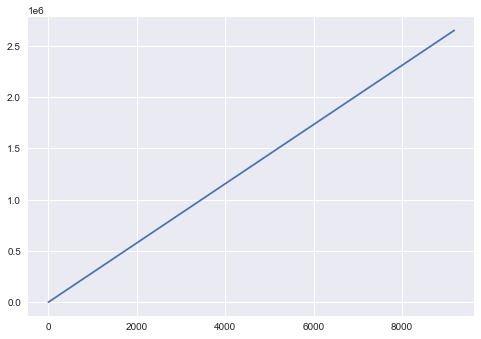

In [128]:
df2.Effort.plot()